# Tutorial 1: Land-cover classification

In this tutorial we are going to explore the power of the **Google Earth Engine** through classifying land-use categories on satelite imagery. In particular, we will focus on supervised classification. Supervised classification refers to the process of using a training dataset with known labels to guide a mathematical classifier in the task of labeling spectral space. They key characteristic is that the training dataset guides (or “supervises”) the labeling.

The `Classifier` package within the **Google Earth Engine** handles supervised classification by traditional ML algorithms running in Earth Engine. These classifiers include CART, RandomForest, NaiveBayes and SVM. The general workflow for classification is:

    1. Collect training data. Assemble features which have a property that stores the known class label and properties storing numeric values for the predictors.
    2. Instantiate a classifier. Set its parameters if necessary.
    3. Train the classifier using the training data.
    4. Classify an image or feature collection.
    5. Estimate the classification error with independent validation data.
    
## Important before we start
<hr>
Make sure that you save this file before you continue, else you will lose everything. To do so, go to Bestand/File and click on Een kopie opslaan in Drive/Save a Copy on Drive!

Now, rename the file into Week5_Tutorial1.ipynb. You can do so by clicking on the name in the top of this screen.

## Learning Objectives
<hr>

- To understand how one can extract data from the **Google Earth Engine**.
- To know how to visualize data from the **Google Earth Engine** in Python.
- To understand and apply a supervised classification algorithm.
- To be able to create training data and a simple classifier.
- To classify Landsat-8 data using various training datasets.
- To be able to compare and judge the performance of a land-use classification.

<h2>Tutorial Outline<span class="tocSkip"></span></h2>
<hr>
<div class="toc"><ul class="toc-item">
<li><span><a href="#1.-Introducing the packages" data-toc-modified-id="1.-Introducing-the-packages-2">1. Introducing the packages</a></span></li>
<li><span><a href="#2.-Extracting and exploring Landsat-8 data" data-toc-modified-id="2.-Extracting-exploring-landsat-3">2. Extracting and exploring Landsat-8 data</a></span></li>
<li><span><a href="#3.-Create training data using Corine Land Cover" data-toc-modified-id="3.-Create-training-data-4">3. Create training data using Corine Land Cover</a></span></li>
<li><span><a href="#4.-Train the classifier using Corine Land Cover" data-toc-modified-id="4.-Classifier-CLC-5">4.-Train the classifier using Corine Land Cover</a></span></li>
<li><span><a href="#5.-Classify the Landsat-8 using Corine Land Cover" data-toc-modified-id="5.-Classify-CLC-6"> 5. Classify the Landsat-8 using Corine Land Cover</a></span></li>
<li><span><a href="#6.-Classify the Landsat-8 using ESA WorldCover" data-toc-modified-id="6.-Classify-ESA-7"> 6. Classify the Landsat-8 using ESA WorldCover</a></span></li>
<li><span><a href="#7.-Analyze and assess your Landsat-8 land cover map" data-toc-modified-id="6.-Analyze-LLC-7"> 7. Analyze and assess your Landsat-8 land cover map</a></span></li></ul></div>

## 1. Introducing the packages
<hr>

Within this tutorial, we are going to make use of the following packages: 

[**ee**](https://developers.google.com/earth-engine/guides/python_install) is a Python package to use the the Google Earth Engine.

[**geemap**](https://geemap.org/) is a Python package for interactive mapping with the Google Earth Engine.

*We will first need to install these packages in the cell below. Uncomment them to make sure we can pip install them*

In [ ]:
#!pip install ee # ee is already available in google colab so no need to install it again
!pip install geemap
!pip install rioxarray

As you may or may not have seen while installing, there was a warning that we need to restart our runtime. To do so, click on **Runtime** in the topbar menu and click on **Runtime opnieuw starten**/**Restart runtime**.

Now we will import these packages in the cell below:

In [2]:
import ee
import geemap
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray as rio

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib.patches import Patch
from matplotlib import rcParams, cycler

## 2.Extracting and exploring the Landsat-8 data
<hr>

Unfortunately it is not as simple as just running the  code below. As soon as you run it, you will notice that you need to authorize ourselves to be able to use the Google Earth Engine.

To do so, we will first have to register ourselves. on the website of the [Google Earth Engine](https://earthengine.google.com/). 

You can choose any location in Europe, but the code below will show the coordinates we have selected for the Netherlands. Feel free to change them.

In [3]:
Map = geemap.Map(height=800,width=700,center=[52.37,4.5],zoom=7)
Map

Map(center=[52.37, 4.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=…

Now we have succesfully managed to see a map of the Netherlands, let's add Landsat data to the map

In [4]:
point = ee.Geometry.Point([5.0, 51.37])
# point = ee.Geometry.Point([-87.7719, 41.8799])

image = (
    ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
    .filterBounds(point)
    .filterDate('2020-01-01', '2020-12-31')
    .sort('CLOUD_COVER')
    .first()
    .select('B[1-7]')
)

vis_params = {'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}

Map.centerObject(point, 8)
Map.addLayer(image, vis_params, "Landsat-8")

It worked! As we have specified that we wanted landsat data with as little clouds as possible, let's check the data and the actual cloud cover:

In [5]:
ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()

'2020-07-31'

In [6]:
image.get('CLOUD_COVER').getInfo()

0.2

<div class="alert alert-block alert-success">
<b>Question 1:</b> Please provide the date and the cloud cover of your map. What does this cloud cover value tell you. Do you think it is good enough? Or do you maybe want to pick a different area. If so, where did you end up eventually (and with which cloud cover)?
</div>

## 3.Create training data using Corine Land Cover
<hr>

Training data is instrumental to supervised image classification. The training dataset is a labeled set of data that is used to inform or “train” a classifier. The trained classifier can then be applied to new data to create a classification. For example, land cover training data will contain examples of each class in the study’s legend. Based on these labels, the classifier can predict the most likely land cover class for each pixel in an image. This is an example of a categorical classification and the training labels are therefore categorical. By contrast, a continuous variable (e.g. percent tree cover) can be predicted using continuous training labels.

Let us first specify the region we are interested in! There are several ways you can create a region for generating the training dataset.

- Draw a shape (e.g., rectangle) on the map and the use `region = Map.user_roi`
- Define a geometry, such as `region = ee.Geometry.Rectangle([-122.6003, 37.4831, -121.8036, 37.8288])`
- Create a buffer zone around a point, such as `region = ee.Geometry.Point([-122.4439, 37.7538]).buffer(10000)`
- If you don't define a region, it will use the image footprint by default

In [7]:
region = ee.Geometry.Point([4.5, 52.37]).buffer(10000)

Now let's explore the Corine Land Cover data.

As you will see in the cell below, we use the path where the data is located within the **Google Earth Engine** and specify that we want to see the landcover. 

Within that same line, we also use the `.clip()` function in which we define that we specifically only want to see the same area as the Landsat-8 image we already selected.

In [8]:
CLC = ee.Image('COPERNICUS/CORINE/V20/100m/2012').select('landcover').clip(image.geometry())

And let's view it on a map again!

In [9]:
Map.addLayer(CLC, {}, 'CLC')
Map

Map(bottom=22233.0, center=[51.37, 4.999999999999999], controls=(WidgetControl(options=['position', 'transpare…

Now we are going to make the training dataset.

In the `sample()` function, we have to specify multiple arguments:

- Through the `region`argument we specify the geographic boundary of our training dataset.
- Through the `scale` argument we specify the size of the points for our sample (30 would indicate 30m).
- Through the `numPixels` argument we specify how many pixels we want to extract.
- Through the `seed` argument we specify which random selection order we want. Through using a seed, you can always reproduce your results.
- Through the `geometries` argument we specify whether we want to extract the geometries as well. This should always be set to True.



In [10]:
points = CLC.sample(
    **{
        'region': image.geometry(),
        'scale': 100,
        'numPixels': 5000,
        'seed': 0,
        'geometries': True,  # Set this to False to ignore geometries
    }
)

<div class="alert alert-block alert-success">
<b>Question 2:</b> Describe the `.sample()` function in your own words. Which values have you chosen? And why?
</div>

Let's check how many points we got for our sample set.

In [11]:

print(points.size().getInfo())

4952


And what is the information within each of the points:

In [12]:
print(points.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [6.262549916271497, 51.256151849693374]}, 'id': '0', 'properties': {'landcover': 211}}


## 4.-Train the classifier using Corine Land Cover
<hr>

Now that we have created the points, we need to sample the Landsat-8 imagery using `.sampleRegions()`. This function will extract the reflectance in the designated bands for each of the points you have created. 

We will use reflectance from the optical, NIR, and SWIR bands (B2 - B7).

In [13]:
# Use these bands for prediction.
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# This property of the table stores the land cover labels.
label = 'landcover'

# Overlay the points on the imagery to get training.
training = image.select(bands).sampleRegions(
    **{'collection': points, 'properties': [label], 'scale': 100}
)

A very important part of training a machine learning algorithm is that you ensure that there is some part of your training data left to validate your results. Here we split approximately  80% of the features into a training set and 20% into a validation set.  

In [14]:
sample = points.randomColumn();
trainingSample = sample.filter('random <= 0.8');
validationSample = sample.filter('random > 0.8');

And finally we extract the pixels from the LandSat-8 imagery a well to finalize our training data

In [15]:
# Overlay the points on the imagery to get training.
training = image.select(bands).sampleRegions(
    **{'collection': trainingSample, 'properties': [label], 'scale': 100}
)

In [16]:
# Overlay the points on the imagery to get training.
validation = image.select(bands).sampleRegions(
    **{'collection': validationSample, 'properties': [label], 'scale': 100}
)

<div class="alert alert-block alert-success">
<b>Question 3:</b> Describe in your own words why we want to split our data into training data and test data. Why is this important for the evaluation of our results?
</div>

## 5. Classify and visualise the Landsat-8 using Corine Land Cover
<hr>

We are going to try various algorithms to see how they perform when we want to classify our LandSat image into land-use categories.

To assess the accuracy of a classifier, we use a `ConfusionMatrix`. The `sample()` method generated two random samples from the input data: one for training and one for validation. The training sample is used to train the classifier. You can get resubstitution accuracy on the training data from `classifier.confusionMatrix()`. To get validation accuracy, we classify the validation data. This adds a `classification` property to the validation `FeatureCollection`. We will call `errorMatrix()` on the classified `FeatureCollection` to get a confusion matrix representing validation (expected) accuracy. Don't worry if things are bit unclear, we will do this step-by-step.

### Random Forests
---
Let's first use Random Forests to classify our satellite image. The inputs are specified in the [documentation](https://developers.google.com/earth-engine/apidocs/ee-classifier-smilerandomforest) of the Google Earth Engine. As you can see from the documentation, the most important input is to specify the amount of trees we are going to use. We will start with **1** and let's have a look how are model performs.

In [17]:
trained_RF = ee.Classifier.smileRandomForest(1).train(training, label, bands)

Let's first have a look at the accuracy of our training data. Accuracy represents the number of correctly classified data instances over the total number of data instances. We can calculate this by estimating a `confusion Matrix` and using the `accuracy()` function. The accuracy value ranges between 0 and 1. A value of 1 indicates that the model has fitted everything correctly.

The `confusionMatrix()` computes a 2D confusion matrix for a classifier based on its training data (ie: resubstitution error). Axis 0 of the matrix correspond to the input classes (i.e., reference data), and axis 1 to the output classes (i.e., classification data). The rows and columns start at class 0 and increase sequentially up to the maximum class value.

The overall Accuracy essentially tells us out of all of the reference sites what proportion were mapped correctly. The overall accuracy is usually expressed as a percent, with 100% accuracy being a perfect classification where all reference site were classified correctly. Overall accuracy is the easiest to calculate and understand but ultimately only provides the map user and producer with basic accuracy information.

In [18]:
trainAccuracy = trained_RF.confusionMatrix()
trainAccuracy.accuracy()

This is not very high. Let's use 10 trees and see how the results compare.

In [19]:
trained_RF = ee.Classifier.smileRandomForest(10).train(training, label, bands)
trainAccuracy = trained_RF.confusionMatrix()
trainAccuracy.accuracy()

This is more like it! What if we increase this towards 100:

In [20]:
trained_RF = ee.Classifier.smileRandomForest(100).train(training, label, bands)
trainAccuracy = trained_RF.confusionMatrix()
trainAccuracy.accuracy()

Almost everything is now classified correctly. can we reach 100% if we would use double the amount of trees?

In [21]:
trained_RF = ee.Classifier.smileRandomForest(200).train(training, label, bands)
trainAccuracy = trained_RF.confusionMatrix()
trainAccuracy.accuracy()

As you noticed, it also took notable longer to get the results. And we didnt gain too much either. It would be interesting to plot these results and see how the results converge:

In [22]:
trees = [1,5,10,25,50,100,200]
collect_accuracies = []
for tree in trees:
    collect_accuracies.append(ee.Classifier.smileRandomForest(tree).train(training, label, bands).confusionMatrix().accuracy().getInfo())

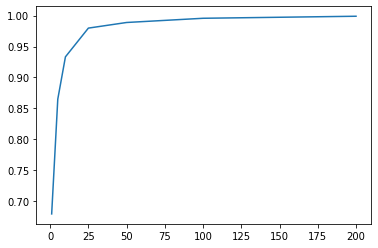

In [23]:
plt.plot(trees,collect_accuracies)

<div class="alert alert-block alert-success">
<b>Question 4:</b>  Upload the figure of your Random Forest Classifier progress.
</div>

<div class="alert alert-block alert-success">
<b>Question 5:</b>  Please describe the figure above. What do you think would be a good value to use, and why?
</div>

The **Kappa Coefficient** is generated from a statistical test to evaluate the accuracy of a classification. **Kappa** essentially evaluates how well the classification performed as compared to just randomly assigning values, i.e. did the classification do better than random. The **Kappa Coefficient** can range from -1 to 1. A value of 0 indicated that the classification is no better than a random classification. A negative number indicates the classification is significantly worse than random. A value close to 1 indicates that the classification is significantly better than random.

In [24]:
trainAccuracy.kappa().getInfo()

0.9988558630086642

Now let's have a look at some validation of our results. Through the using the 20% we reserved for validation, we can see how the model performs for the data that we did not use to train our model. `errorMatrix` computes a 2D error matrix for a collection by comparing two columns of a collection: one containing the actual values, and one containing predicted values.

In [25]:
validationSample = validation.classify(trained_RF)
validationAccuracy = validationSample.errorMatrix(label, 'classification')
validationAccuracy.accuracy()

<div class="alert alert-block alert-success">
<b>Question 6:</b> Which values did you obtain for Kappa and your validation sample. Please interpret them.
</div>

### CART Classifier
---
Next, we use a **CART** classifier to find the best method to use the spectral values to separate the labels. The classifiers known as Classification and Regression Trees (CART) partition the spectral data space successive binary splits arranged in a tree form. Graphically, classification trees identify lines that successively split the data space to separate the training points into their classes.

In [26]:
trained_CART = ee.Classifier.smileCart().train(training, label, bands)

Get a confusion matrix and overall accuracy for the training sample.

In [27]:
trainAccuracy = trained_CART.confusionMatrix()
trainAccuracy.accuracy()

Get a confusion matrix and overall accuracy for the validation sample.

In [28]:
validationSample = validation.classify(trained_CART)
validationAccuracy = validationSample.errorMatrix(label, 'classification')
validationAccuracy.accuracy()

### Naive Bayes
---
Now let's try to use the **Naive Bayes** classifier. This is classification approach that adopts the principle of class conditional independence from the Bayes Theorem. This means that the presence of one feature does not impact the presence of another in the probability of a given outcome, and each predictor has an equal effect on that result. 

In [29]:
trained_NaiveBayes = ee.Classifier.smileNaiveBayes().train(training, label, bands)

And let's get the overall accuracy of the training data:

In [30]:
trainAccuracy = trained_NaiveBayes.confusionMatrix()
trainAccuracy.accuracy()

And the results of our validation data:

In [31]:
validationSample = validation.classify(trained_NaiveBayes)
validationAccuracy = validationSample.errorMatrix(label, 'classification')
validationAccuracy.accuracy()

<div class="alert alert-block alert-success">
<b>Question 7:</b> Describe the results of the CART classifier and the Naive Bayes. How did they perform and why do you think the results are different between them?
</div>

### Support Vector Machine
---
And Finally, we will use a **Support Vector Machine**. This is a popular supervised learning model developed by Vladimir Vapnik, used for both data classification and regression. That said, it is typically leveraged for classification problems, constructing a hyperplane where the distance between two classes of data points is at its maximum. This hyperplane is known as the decision boundary, separating the classes of data points (e.g., oranges vs. apples) on either side of the plane.

As you can see in the cell below, to make sure we can run the **Support Vector Machine**, we substantially reduce our training data to only 20%, instead of 80%. We do this, because running the classifier on the entire training dataset would take an extremely long time to run.

In [32]:
trainingSample_SVM = sample.filter('random <= 0.2');
validationSample_SVM = sample.filter('random > 0.8');

In [33]:
# Overlay the points on the imagery to get training.
training_SVM = image.select(bands).sampleRegions(
    **{'collection': trainingSample_SVM, 'properties': [label], 'scale': 100}
)

# Overlay the points on the imagery to get training.
validation_SVM = image.select(bands).sampleRegions(
    **{'collection': validationSample_SVM, 'properties': [label], 'scale': 100}
)

In [34]:
trained_SVM = ee.Classifier.libsvm().train(training_SVM, label, bands)

Now let's have a look at the accuracy again of our training data

In [35]:
trainAccuracy = trained_SVM.confusionMatrix()
trainAccuracy.accuracy()

And the results of our validation data:

In [36]:
validationSample = validation_SVM.classify(trained_SVM)
validationAccuracy = validationSample.errorMatrix(label, 'classification')
validationAccuracy.accuracy()

<div class="alert alert-block alert-success">
<b>Question 8:</b> Describe the results of the Support Vector Machine. Are you surprised by the outcome?
</div>

### Classify and visualize output
---
Now let's classify the image with the same bands used for training, using the Random Forest model.

In [37]:
CLC_Classified = image.select(bands).classify(trained_RF)

Let's look at the results on a map.

In [38]:
Map.addLayer(CLC_Classified.randomVisualizer(), {}, 'classified')
Map

Map(bottom=22233.0, center=[51.37, 4.999999999999999], controls=(WidgetControl(options=['position', 'transpare…

To render a categorical map, we can set two image properties: `landcover_class_values` and `landcover_class_palette`. We can use the same style as the CLC so that it is easy to compare the two maps. 

In [39]:
class_values = CLC.get('landcover_class_values').getInfo()
class_palette = CLC.get('landcover_class_palette').getInfo()

landcover = CLC_Classified.set('classification_class_values', class_values)
landcover = landcover.set('classification_class_palette', class_palette)

Now we can plot the results again but use the Corine Land Cover legend and colorscheme

In [40]:
Map.addLayer(landcover, {}, 'Land cover')
Map.add_legend(builtin_legend='COPERNICUS/CORINE/V20/100m')
Map

Map(bottom=22233.0, center=[51.37, 4.999999999999999], controls=(WidgetControl(options=['position', 'transpare…

## 6. Classify the Landsat-8 using ESA WorldCover
<hr>

While the Corine Land Cover data provides us with some promising results, it would be interesting to see if we can do something similar using a different data source. To do so, we are going to make use of the ESA WorldCover data.

Let's start again with exploring the data:

In [41]:
ESA = ee.Image('ESA/WorldCover/v100/2020').clip(image.geometry())
Map.addLayer(ESA, {}, 'ESA')
Map

Map(bottom=22233.0, center=[51.37, 4.999999999999999], controls=(WidgetControl(options=['position', 'transpare…

And now we generate the training set again:

In [42]:
classValues = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
remapValues = ee.List.sequence(0, 10)
label = 'lc'
lc = ESA.remap(classValues, remapValues).rename(label).toByte()

sample = image.addBands(lc).stratifiedSample(
    **{
  'numPoints': 5000,
  'classBand': label,
  'region': image.geometry(),
  'scale': 100,
  'geometries': True
})

And again, we split the data into training and validation.

In [43]:

sample = sample.randomColumn();
trainingSample = sample.filter('random <= 0.8');
validationSample = sample.filter('random > 0.8');

As the **CART** classifier performed best, we will re-use this one to train the algorithm through using the ESA WorldCover data.

In [44]:
trainedClassifier = ee.Classifier.smileCart().train(
    **{
  'features': trainingSample,
  'classProperty': label,
  'inputProperties': image.bandNames()
});

In [45]:
trainAccuracy = trainedClassifier.confusionMatrix()
trainAccuracy.accuracy()

Resulting in our newly classified map

In [46]:
ESAWorldCover_classified = image.classify(trainedClassifier)

And let's visualize this!

In [47]:
classVis = {
  'min': 0,
  'max': 10,
  'palette': ['006400' ,'ffbb22', 'ffff4c', 'f096ff', 'fa0000', 'b4b4b4',
            'f0f0f0', '0064c8', '0096a0', '00cf75', 'fae6a0']
};

#Map.addLayer(lc, classVis, 'lc');
Map.addLayer(ESAWorldCover_classified, classVis, 'Classified');
Map

Map(bottom=22233.0, center=[51.37, 4.999999999999999], controls=(WidgetControl(options=['position', 'transpare…

## 7. Analyze and assess your Landsat-8 land cover map
<hr>

Now we have two land cover maps generated for most part of the Netherlands, let's analyze and judge their quality.

To do so, you can either zoom in on the same area you used last week to learn OpenStreetMap, or specify a different area when it is outside the bounds of our land cover map.

We do so, by creating a bounding box. You can use [this website](https://boundingbox.klokantech.com/) to create a bounding box. Once you have created a bounding box, you can select the 'CSV' tab and copy paste the coordinates in the cell below.

In [48]:
bbox = [4.248882,51.853884,4.542965,52.018829]

And now we can translate this into a rectangle to be used with the **Google Earth Engine**:

In [49]:
focus_region = ee.Geometry.Rectangle([bbox[0], 
                       bbox[1],
                       bbox[2],
                       bbox[3]])

### Corine Land Cover

We will start with identifying how well Corine Land Cover data has been classified with our classifier. To do so, we will first download the images from the **Google Earth Engine**. To do that, we will use the `ee_export_image()` function. 

In [50]:
geemap.ee_export_image(
    CLC, filename='CLC.tif', scale=100, file_per_band=False,region=focus_region
)

geemap.ee_export_image(
    CLC_Classified, filename='CLC_Classified.tif', scale=100, file_per_band=False,region=focus_region
)

Generating URL ...
Please wait ...
Data downloaded to /content/CLC.tif
Generating URL ...
Please wait ...
Data downloaded to /content/CLC_Classified.tif


Now we can use **xarray** to open the geotiffs and prepare them for visualisation.

In [51]:
CLC_original = xr.open_dataset('CLC.tif', engine = 'rasterio')
CLC_original = CLC_original.rename({'x': 'lat','y': 'lon'})
CLC_original.rio.set_spatial_dims(x_dim="lat",y_dim="lon", inplace=True)

CLC_classified = xr.open_dataset('CLC_Classified.tif', engine = 'rasterio')
CLC_classified = CLC_classified.rename({'x': 'lat','y': 'lon'})
CLC_classified.rio.set_spatial_dims(x_dim="lat",y_dim="lon", inplace=True)

<xarray.Dataset>
Dimensions:      (band: 1, lat: 206, lon: 188)
Coordinates:
  * band         (band) int64 1
  * lat          (lat) float64 5.857e+05 5.858e+05 ... 6.061e+05 6.062e+05
  * lon          (lon) float64 5.764e+06 5.764e+06 ... 5.746e+06 5.746e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, lon, lat) float32 ...

Let's plot the original map (left) and the classified map (right).

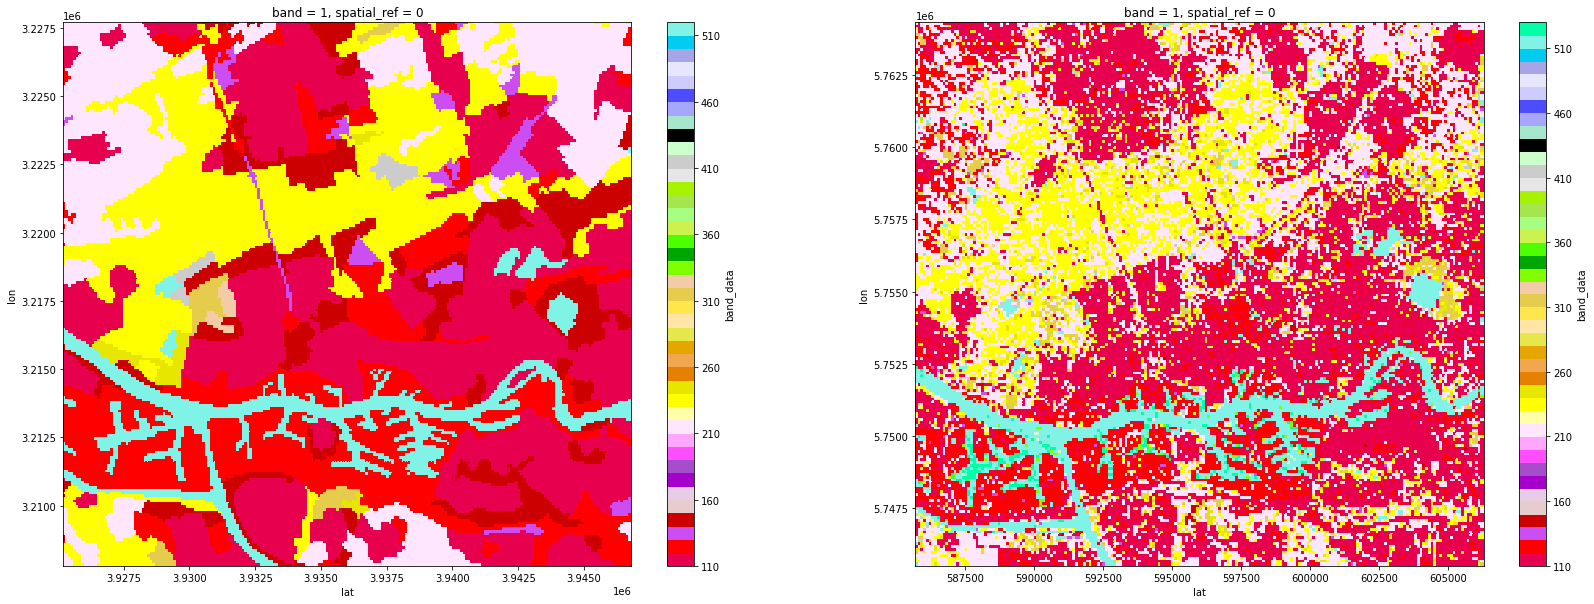

In [52]:
fig, axes = plt.subplots(1, 2,figsize=(28,10))

class_palette_coded = ['#'+x for x in class_palette]

CLC_original["band_data"].plot(ax=axes[0],levels=len(class_palette_coded),colors=class_palette_coded)
CLC_classified["band_data"].plot(ax=axes[1],levels=len(class_palette_coded),colors=class_palette_coded)

<div class="alert alert-block alert-success">
<b>Question 9:</b> Please upload the comparison figure of the original Corine Land Cover data and the classified map. 
</div>


<div class="alert alert-block alert-success">
<b>Question 10:</b> Describe the results of the Corine Land Cover classification. How do you think the model has performed when you zoom in on a specific area. Do you notice specific land-use classes to be worse than expected? Or better than expected? Please elaborate. 
</div>

<div class="alert alert-block alert-success">
<b>Question 11:</b> Obtain the Corine Land Cover results once more by using a different classification model. How do the results change. Have they become better, or worse? Please elaborate.
</div>

### ESA World Cover

Now let's do the same for our ESA World Cover. We start with downloading the results again.

In [53]:
geemap.ee_export_image(
    ESA, filename='ESAWorldCover.tif', scale=100,region=focus_region, file_per_band=False
)

geemap.ee_export_image(
    ESAWorldCover_classified, filename='ESAWorldCover_classified.tif', scale=100,region=focus_region, file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/ESAWorldCover.tif
Generating URL ...
Please wait ...
Data downloaded to /content/ESAWorldCover_classified.tif


Load the data again:

In [54]:
ESA_original = xr.open_dataset('ESAWorldCover.tif', engine="rasterio")
ESA_original = ESA_original.rename({'x': 'lat','y': 'lon'})
ESA_original.rio.set_spatial_dims(x_dim="lat",y_dim="lon", inplace=True)

ESA_classified = xr.open_dataset('ESAWorldCover_classified.tif', engine="rasterio")
ESA_classified = ESA_classified.rename({'x': 'lat','y': 'lon'})
ESA_classified.rio.set_spatial_dims(x_dim="lat",y_dim="lon", inplace=True)
ESA_classified['band_data'] = ESA_classified['band_data']*10

And now we create the `color_dict` for the ESA WorldCover:

In [55]:
ESA_values = [ 10,  20,  30,  40,  50,  60,  70,  80,  90, 95, 100]
ESA_palette = ['#006400' ,'#ffbb22', '#ffff4c', '#f096ff', '#fa0000', '#b4b4b4',
            '#f0f0f0', '#0064c8', '#0096a0', '#00cf75', '#fae6a0']

But our clipped data is looking a litle bit different. Let's have a look at the values for the original data:

In [56]:
np.unique(ESA_original['band_data'])

array([10., 20., 30., 40., 50., 60., 80., 90.], dtype=float32)

And our classified data

In [57]:
np.unique(ESA_classified['band_data'])

array([10., 20., 30., 40., 50., 70., 80., nan], dtype=float32)

If we look at the [Land Cover classes](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100), we see that we may not have some of the higher values in the Netherlands. So let's create a palette with just the land cover classes we have in the Netherlands 

In [58]:
original_palette = [ESA_palette[int(x/10)-1] for x 
                      in np.unique(ESA_original['band_data'])]

In [59]:
classified_palette = [ESA_palette[int(x/10)-1] for 
                      x in np.unique(ESA_classified['band_data']) if ~np.isnan(x)]+['#000000']

And plot the two maps to compare

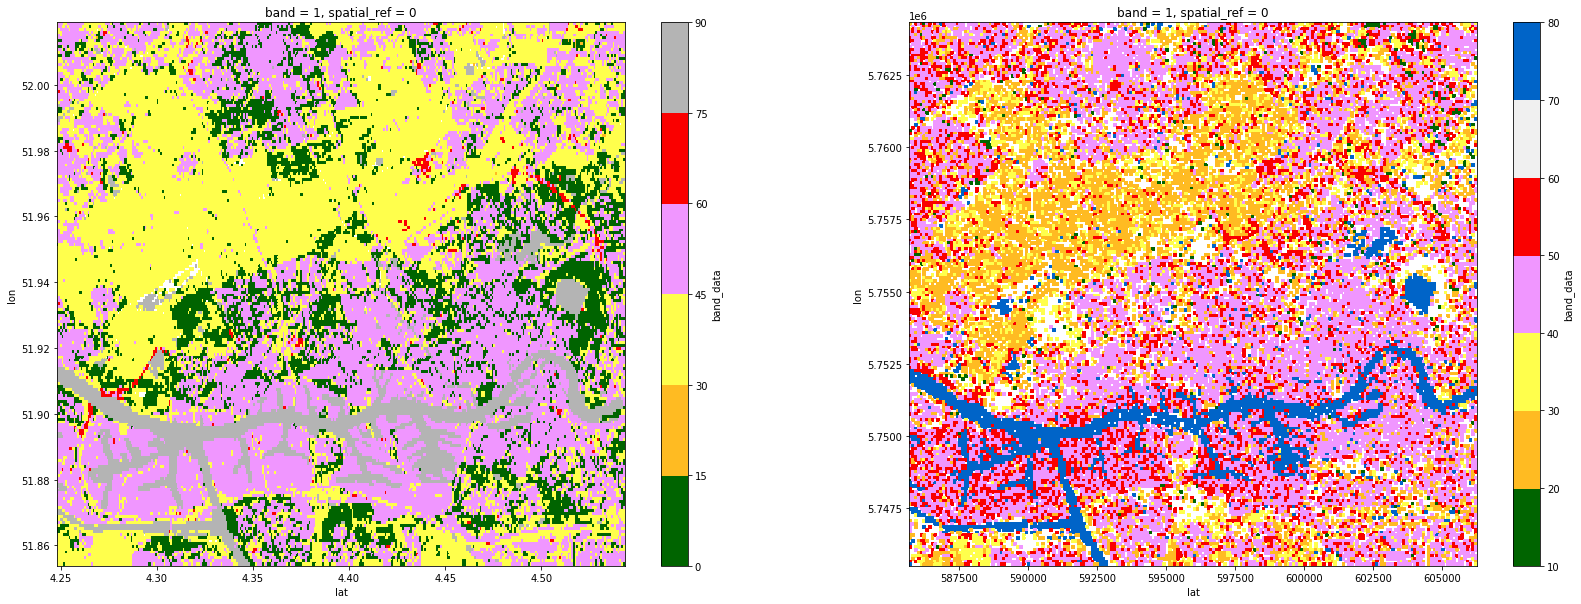

In [60]:
fig, axes = plt.subplots(1, 2,figsize=(28,10))

ESA_original["band_data"].plot(ax=axes[0],levels=len(original_palette),colors=original_palette)
ESA_classified["band_data"].plot(ax=axes[1],levels=len(classified_palette),colors=classified_palette)